Delta_TL

Using device: cuda


/tmp/ipykernel_8790/649741636.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))



--- Test File Evaluation ---
RMSE: 0.9417
MAE:  0.7013
R²:   0.9846


/tmp/ipykernel_8790/649741636.py:102: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


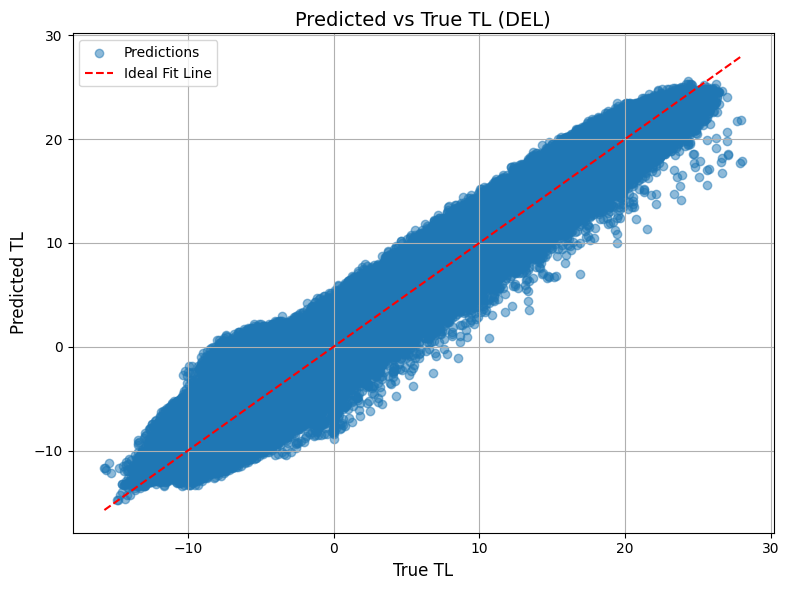

In [7]:
import os
import numpy as np
import pandas as pd
import joblib
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === SETTINGS ===
model_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/LSTM/Model/lstm_tl.pth'
scaler_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/LSTM/Scalers/lstm_tl.save'
csv_file = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/Test/final_file.csv'  # <<< CHANGE THIS IF REQUIRED
seq_len = 24
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# === Load Scalers and Model ===
scalers = joblib.load(scaler_path)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=12, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])

n_features = len(scalers)
model = LSTMModel(input_size=n_features, hidden_size=12)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# === Load CSV and Preprocess ===
df = pd.read_csv(csv_file)
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']], errors='coerce')
df = df.dropna(subset=['Date'])
df['DayOfYear'] = df['Date'].dt.dayofyear
df['HourOfDay'] = df['Date'].dt.hour
df['sin_doy'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.0)
df['cos_doy'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.0)
df['sin_hour'] = np.sin(2 * np.pi * df['HourOfDay'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['HourOfDay'] / 24)

# Select required columns in correct order
df = df[['AirTemp', 'Wind', 'Tdp', 'Solar', 'sin_doy', 'cos_doy', 'sin_hour', 'cos_hour', 'Depth', 'Albedo', 'TL']].dropna().reset_index(drop=True)

def make_sequences(df, seq_len):
    arr = df.drop(columns='TL').to_numpy(dtype=np.float32)
    targets = df['TL'].to_numpy(dtype=np.float32)
    n_samples = len(df) - seq_len
    X = np.stack([arr[i:i+seq_len] for i in range(n_samples)], dtype=np.float32)
    y = targets[seq_len:]
    return X, y

if len(df) < seq_len + 2:
    raise ValueError("Insufficient data to generate sequences!")

X, y_true = make_sequences(df, seq_len)

# === Scale features ===
for i in range(n_features):
    X[:, :, i] = scalers[i].transform(X[:, :, i])

# === Predict in batches, move only batches to GPU ===
X_tensor = torch.from_numpy(X).float()  # Keep on CPU

with torch.no_grad():
    preds = []
    batch_size = 1024  # reduce if still hitting OOM
    for i in range(0, len(X_tensor), batch_size):
        batch = X_tensor[i:i+batch_size].to(device)  # Move batch to GPU
        pred = model(batch).cpu().numpy()            # Back to CPU
        preds.append(pred)

y_pred = np.concatenate(preds).flatten()

# === Evaluation ===
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n--- Test File Evaluation ---")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# === Scatter Plot ===
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5, label='Predictions')
min_val = min(np.min(y_true), np.min(y_pred))
max_val = max(np.max(y_true), np.max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit Line')

plt.xlabel("True TL", fontsize=12)
plt.ylabel("Predicted TL", fontsize=12)
plt.title("Predicted vs True TL (DEL)", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


CESR

Using device: cuda


/tmp/ipykernel_8790/3441289347.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))



--- Test File Evaluation ---
RMSE: 0.0180
MAE:  0.0084
R²:   0.9823


/tmp/ipykernel_8790/3441289347.py:102: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/bel/Desktop/Shiv_SRIP/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


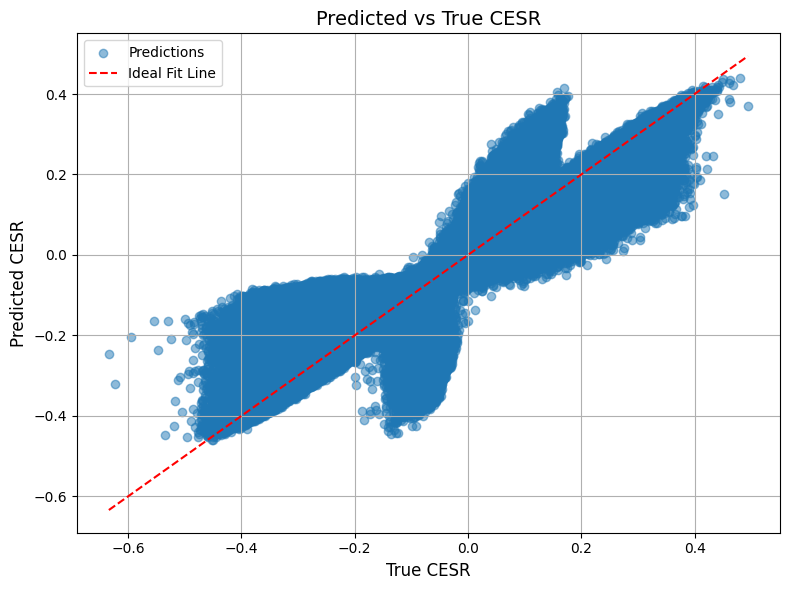

In [8]:
import os
import numpy as np
import pandas as pd
import joblib
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === SETTINGS ===
model_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/LSTM/Model/lstm_cesr.pth'
scaler_path = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/LSTM/Scalers/lstm_cesr.save'
csv_file = '/home/bel/Desktop/Shiv_SRIP/ATenLoc/Test/final_file.csv'  # <<< CHANGE THIS IF REQUIRED
seq_len = 24
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# === Load Scalers and Model ===
scalers = joblib.load(scaler_path)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=12, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])

n_features = len(scalers)
model = LSTMModel(input_size=n_features, hidden_size=12)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# === Load CSV and Preprocess ===
df = pd.read_csv(csv_file)
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']], errors='coerce')
df = df.dropna(subset=['Date'])
df['DayOfYear'] = df['Date'].dt.dayofyear
df['HourOfDay'] = df['Date'].dt.hour
df['sin_doy'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.0)
df['cos_doy'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.0)
df['sin_hour'] = np.sin(2 * np.pi * df['HourOfDay'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['HourOfDay'] / 24)

# Select required columns in correct order
df = df[['AirTemp', 'Wind', 'Tdp', 'Solar', 'sin_doy', 'cos_doy', 'sin_hour', 'cos_hour', 'Depth', 'Albedo', 'CESR']].dropna().reset_index(drop=True)

def make_sequences(df, seq_len):
    arr = df.drop(columns='CESR').to_numpy(dtype=np.float32)
    targets = df['CESR'].to_numpy(dtype=np.float32)
    n_samples = len(df) - seq_len
    X = np.stack([arr[i:i+seq_len] for i in range(n_samples)], dtype=np.float32)
    y = targets[seq_len:]
    return X, y

if len(df) < seq_len + 2:
    raise ValueError("Insufficient data to generate sequences!")

X, y_true = make_sequences(df, seq_len)

# === Scale features ===
for i in range(n_features):
    X[:, :, i] = scalers[i].transform(X[:, :, i])

# === Predict in batches, move only batches to GPU ===
X_tensor = torch.from_numpy(X).float()  # Keep on CPU

with torch.no_grad():
    preds = []
    batch_size = 1024  # reduce if still hitting OOM
    for i in range(0, len(X_tensor), batch_size):
        batch = X_tensor[i:i+batch_size].to(device)  # Move batch to GPU
        pred = model(batch).cpu().numpy()            # Back to CPU
        preds.append(pred)

y_pred = np.concatenate(preds).flatten()

# === Evaluation ===
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n--- Test File Evaluation ---")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# === Scatter Plot ===
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5, label='Predictions')
min_val = min(np.min(y_true), np.min(y_pred))
max_val = max(np.max(y_true), np.max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit Line')

plt.xlabel("True CESR", fontsize=12)
plt.ylabel("Predicted CESR", fontsize=12)
plt.title("Predicted vs True CESR", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
